#                                    ECE-457 Introduction to Computer Vision
##                                        Final Project/Image Stiching
 ###                               Ελίσα Οσμενλλάρι, 03605 & Ελένη Τσιτώνη, 03447


In [298]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

## Custom Perspective Transformation & Compute Dimensions & Homography functions & RANSAC

In [310]:
def custom_perspective_transform(points, H):
    """
    Δέχεται έναν πίνακα points με σχήμα (N,2) και μία 3x3 ομογραφία H.
    Επιστρέφει τα μετασχηματισμένα σημεία ως πίνακα (N,2).
    """
    num_points = points.shape[0]
    points_hom = np.hstack((points, np.ones((num_points, 1))))
    transformed_hom = points_hom @ H.T
    transformed = transformed_hom[:, :2] / transformed_hom[:, 2, np.newaxis]
    return transformed

def compute_image_corners(img, H):
    """
    Υπολογίζει τις 4 γωνίες της εικόνας και τις μετατρέπει με την ομογραφία H.
    """
    h, w = img.shape[:2]
    corners = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32)
    pers_corners = custom_perspective_transform(corners, H)
    return pers_corners

def compute_panorama_dimensions(images, transforms):
    """
    Δέχεται λίστα εικόνων και τις αντίστοιχες ομογραφίες (3x3).
    Υπολογίζει το συνολικό bounding box που περιέχει όλες τις μετασχηματισμένες γωνίες.
    
    Επιστρέφει: (width, height, x_min, y_min)
    """
    all_corners = []
    for img, H in zip(images, transforms):
        corners = compute_image_corners(img, H)
        all_corners.append(corners)
    all_corners = np.vstack(all_corners)
    
    x_coords = all_corners[:, 0]
    y_coords = all_corners[:, 1]
    
    x_min = int(np.floor(np.min(x_coords)))
    x_max = int(np.ceil(np.max(x_coords)))
    y_min = int(np.floor(np.min(y_coords)))
    y_max = int(np.ceil(np.max(y_coords)))
    
    width = x_max - x_min
    height = y_max - y_min
    return width, height, x_min, y_min

######################################
# Custom SVD & Homography Computation
######################################
def custom_svd(A):
    """
    Υπολογίζει τον eigenvector της ελαχίστης ιδιοτιμής του A.T @ A.
    Επιστρέφει τον πραγματικό μέρος του eigenvector.
    """
    ATA = A.T @ A
    eigvals, eigvecs = np.linalg.eig(ATA)
    idx = np.argmin(eigvals)
    smallest_vec = eigvecs[:, idx]
    return np.real(smallest_vec)

def compute_homography(pts_src, pts_dst):
    """
    Υπολογίζει την ομογραφία μεταξύ των πλαισίων (points_src, points_dst) χρησιμοποιώντας
    τον αλγόριθμο constrained least squares μέσω SVD.
    """
    A = []
    for i in range(len(pts_src)):
        x1, y1 = pts_src[i]
        x2, y2 = pts_dst[i]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
    A = np.array(A)
    h = custom_svd(A)
    H = h.reshape(3, 3)
    if H[2,2] != 0:
        H = H / H[2,2]
    return H
    

def ransac_homography(matches, kp1, kp2, max_iterations=3000, threshold=1.0):
    """
    Εφαρμόζει τον αλγόριθμο RANSAC για τον υπολογισμό της ομογραφίας.
    Επιλέγει τυχαία 4 αντιστοιχίσεις, υπολογίζει υποψήφια ομογραφία και μετράει τους inliers.
    Επιστρέφει την καλύτερη ομογραφία και τις inlier αντιστοιχίες.
    """
    best_H = None
    best_inliers = None
    max_inlier_count = 0
    ptsA = np.float32([kp1[m.queryIdx].pt for m in matches])
    ptsB = np.float32([kp2[m.trainIdx].pt for m in matches])
    N = ptsA.shape[0]
    if N < 4:
        return None, None
    for _ in range(max_iterations):
        idx = np.random.choice(N, 4, replace=False)
        H_candidate = compute_homography(ptsA[idx], ptsB[idx])
        ptsA_h = np.hstack([ptsA, np.ones((N,1))])
        
        projected = (H_candidate @ ptsA_h.T).T
        projected /= projected[:, [2]]
        diff = ptsB - projected[:, :2]
        dist = np.sqrt((diff**2).sum(axis=1))
        
        inliers = dist < threshold
        inlier_count = np.sum(inliers)
        
        if inlier_count > max_inlier_count:
            max_inlier_count = inlier_count
            best_inliers = inliers
            best_H = H_candidate
    if best_inliers is not None:
        best_H = compute_homography(ptsA[best_inliers], ptsB[best_inliers])
    return best_H, best_inliers

def find_homography_between_images(imgA, imgB):
    """
    Εντοπίζει SIFT keypoints και descriptors στις εικόνες imgA και imgB,
    βρίσκει αντιστοιχίσεις, εφαρμόζει RANSAC για την εκτίμηση της ομογραφίας
    και επιστρέφει την ομογραφία, τους keypoints, τις αρχικές αντιστοιχίσεις και τα inliers.
    """
    grayA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kpA, desA = sift.detectAndCompute(grayA, None)
    kpB, desB = sift.detectAndCompute(grayB, None)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desA, desB)
    matches = sorted(matches, key=lambda x: x.distance)
    H, inliers = ransac_homography(matches, kpA, kpB)
    return H, kpA, kpB, matches, inliers

######################################
# Custom Warp Perspective
######################################


def custom_warp(src, H, pan_size, borderValue=(0,0,0)):
    """
    Εφαρμόζει την ομογραφία H στην εικόνα src ώστε να μεταφερθεί στο νέο coordinate system.
    Για κάθε pixel του destination, γίνεται back-mapping στο source με χρήση του αντίστροφου H.
    Χρησιμοποιεί nearest neighbor interpolation και αν το σημείο είναι εκτός ορίων, 
    επιστρέφει την τιμή borderValue.
    """
    width, height = pan_size
    src_h, src_w = src.shape[:2]
    
    # Δημιουργούμε το output image με το ίδιο dtype και number of channels με την src.
    if src.ndim == 3:
        channels = src.shape[2]
        warped = np.empty((height, width, channels), dtype=src.dtype)
    else:
        warped = np.empty((height, width), dtype=src.dtype)
    
    H_inv = np.linalg.inv(H)
    
    for i in range(height):
        for j in range(width):
            # Δημιουργούμε το σημείο προορισμού (destination) σε ομογενείς συντεταγμένες
            dest_pt = np.array([j, i, 1])
            # Εφαρμόζουμε το αντίστροφο H για back-mapping στο πηγαίο σύστημα
            src_pt = H_inv @ dest_pt
            src_pt /= src_pt[2]
            x, y = src_pt[0], src_pt[1]
            
            # Χρησιμοποιούμε nearest neighbor interpolation
            xi = int(round(x))
            yi = int(round(y))
            
            # Έλεγχος ορίων: αν το σημείο βρίσκεται εκτός, χρησιμοποιούμε borderValue
            if xi < 0 or xi >= src_w or yi < 0 or yi >= src_h:
                pixel = borderValue
            else:
                pixel = src[yi, xi]
            
            warped[i, j] = pixel
    
    return warped


## Blending Functions

In [300]:

def create_overlap_mask(imgA, imgB):
    """
    Δημιουργεί δυαδικό mask που δείχνει την περιοχή overlap μεταξύ των δύο εικόνων.
    Οι εικόνες μετατρέπονται σε grayscale και τα pixels με τιμή > 0 θεωρούνται έγκυρα.
    
    Επιστρέφει:
      overlap_mask: Δυαδικός πίνακας με τιμές 0 ή 1.
    """
    
    grayA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
    maskA = (grayA > 0).astype(np.uint8)
    maskB = (grayB > 0).astype(np.uint8)
    overlap_mask = cv2.bitwise_and(maskA, maskB)
    return overlap_mask

def compute_linear_weight(overlap_mask):
    """
    Υπολογίζει ένα continuous weight mask βάσει της οριζόντιας περιοχής επικάλυψης.
    Βρίσκει το bounding box (x_min, x_max) των pixels όπου το overlap_mask έχει τιμή 1
    και ορίζει το βάρος:
         weight(x) = (x_max - x) / (x_max - x_min)
    για x στο [x_min, x_max]. Εκτός, ορίζεται 1 για x < x_min και 0 για x > x_max.
    
    Επιστρέφει:
      weight: Πίνακας με τιμές στο [0,1].
    """
    coords = cv2.findNonZero(overlap_mask)
    if coords is None:
        # Αν δεν υπάρχει overlap, επιστρέφουμε ένα πίνακα με 0.
        return np.zeros_like(overlap_mask, dtype=np.float32)
    x_coords = coords[:,0,0]
    x_min = int(np.min(x_coords))
    x_max = int(np.max(x_coords))
    h, w = overlap_mask.shape
    weight_mask = np.zeros((h, w), dtype=np.float32)
    for x in range(w):
        if x < x_min:
            weight_mask[:, x] = 1.0
        elif x > x_max:
            weight_mask[:, x] = 0.0
        else:
            # Γραμμική μείωση του βάρους από 1 στο x_min σε 0 στο x_max
            weight_mask[:, x] = (x_max - x) / (x_max - x_min) if (x_max - x_min) != 0 else 0
    return weight_mask


def simple_blend(imgA, imgB):
    """
    Εφαρμόζει simple averaging blending στις δύο εικόνες, χρησιμοποιώντας ένα overlap mask.
    Στην περιοχή όπου υπάρχει overlap (δηλαδή, το overlap_mask έχει τιμή 1), γίνεται ο μέσος όρος.
    Εκτός overlap, διατηρείται το pixel της εικόνας που έχει δεδομένα.
    
    Επιστρέφει:
      blended: Η τελική blended εικόνα.
    """
    # Δημιουργούμε το overlap mask
    overlap_mask = create_overlap_mask(imgA, imgB)
    # Μετατροπή σε boolean array
    overlap_mask_bool = overlap_mask.astype(bool)
    
    # Μετατροπή εικόνων σε float για ακριβείς υπολογισμούς
    A = imgA.astype(np.float32)
    B = imgB.astype(np.float32)
    
    # Αρχικοποιούμε το αποτέλεσμα ως αντιγραφή της πρώτης εικόνας
    blended = A.copy()
    
    # Στην περιοχή overlap, ο μέσος όρος
    blended[overlap_mask_bool] = 0.5 * A[overlap_mask_bool] + 0.5 * B[overlap_mask_bool]
    
    # Εκτός overlap: όπου η εικόνα A έχει δεδομένα, διατηρείται, αλλιώς παίρνουμε τα δεδομένα της B.
    non_overlap = ~overlap_mask_bool
    
    blended[non_overlap] = np.where(A[non_overlap] != 0, A[non_overlap], B[non_overlap])
    
    return np.clip(blended, 0, 255).astype(np.uint8)

def linear_blend(imgA, imgB, a):
    """
    Εφαρμόζει linear blending στις δύο εικόνες χρησιμοποιώντας ένα continuous weight mask
    που υπολογίζεται βάσει του overlap μεταξύ τους.
    
    Ο υπολογισμός γίνεται ως:
      blended = α * imgA + (1 - α) * imgB
      
    Επιστρέφει:
      blended: Η τελική blended εικόνα.
    """
    # Δημιουργία overlap mask (binary)
    overlap_mask = create_overlap_mask(imgA, imgB)
    overlap_mask_bool = overlap_mask.astype(bool)
    
    # Μετατροπή εικόνων σε float
    A = imgA.astype(np.float32)
    B = imgB.astype(np.float32)
    
    # Επέκταση του mask σε 3 κανάλια
    overlap_mask_bool3 = np.repeat(overlap_mask_bool[..., np.newaxis], 3, axis=2)
    
    blended = np.where(overlap_mask_bool3, a * A + (1 - a) * B, np.where(A != 0, A, B))
    
    return np.clip(blended, 0, 255).astype(np.uint8)

def linear_blend_with_weight(imgA, imgB):
    """
    Εφαρμόζει linear blending στις δύο εικόνες χρησιμοποιώντας ένα continuous weight mask
    που υπολογίζεται βάσει του overlap μεταξύ τους.
    
    Ο υπολογισμός γίνεται ως:
      blended = weight * imgA + (1 - weight) * imgB
      
    Επιστρέφει:
      blended: Η τελική blended εικόνα.
    """
    # Δημιουργία overlap mask
    overlap_mask = create_overlap_mask(imgA, imgB)
    overlap_mask_bool = overlap_mask.astype(bool)
    # Υπολογισμός continuous weight mask
    weight_mask = compute_linear_weight(overlap_mask)
    
    # Μετατροπή εικόνων σε float
    A = imgA.astype(np.float32)
    B = imgB.astype(np.float32)
    
    weight_mask3 = weight_mask[..., np.newaxis]

    overlap_mask_bool = np.repeat(overlap_mask_bool[..., np.newaxis], 3, axis=2)

    # Υπολογισμός blended αποτελέσματος
    blended = np.where(overlap_mask_bool, weight_mask3 * A + (1 - weight_mask3) * B, np.where(A != 0, A, B))
    
    return np.clip(blended, 0, 255).astype(np.uint8), weight_mask3




## Main : Load, Warping & Stitching 3 Images 

In [301]:
img1 = cv2.imread("images/img1.jpg")  # Αριστερή εικόνα
img2 = cv2.imread("images/img2.jpg")  # Κεντρική εικόνα (λειτουργεί ως αναφορά για τις υπόλοιπες εικόνες οι οποίες "χαρτογραφούνται με βάση αυτή)
img3 = cv2.imread("images/img3.jpg")  # Δεξιά εικόνα

In [302]:
# Υπολογισμός ομογραφιών και εμφάνιση SIFT matches για τα ζεύγη img1–img2 και img3–img2
H1, kp1, kp2, matches12, inliers12 = find_homography_between_images(img1, img2)
H3, kp3, kp4, matches32, inliers32 = find_homography_between_images(img3, img2)
H2 = np.eye(3, dtype=np.float32)

# img1-img2
img_all_matches12 = cv2.drawMatches(img1, kp1, img2, kp2, matches12, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Δημιουργία λίστας με μόνο τα inliers για το ίδιο ζεύγος:
indices_inliers12 = np.where(inliers12)[0]
inlier_matches12 = [matches12[i] for i in indices_inliers12]
img_inliers12 = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches12, None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Επαναλάβετε για το ζεύγος img3–img2:
img_all_matches32 = cv2.drawMatches(img3, kp3, img2, kp4, matches32, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
indices_inliers32 = np.where(inliers32)[0]
inlier_matches32 = [matches32[i] for i in indices_inliers32]
img_inliers32 = cv2.drawMatches(img3, kp3, img2, kp4, inlier_matches32, None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

Img1-Img2: Inliers = 528 / Total Matches = 699
Img3-Img2: Inliers = 700 / Total Matches = 835


(-0.5, 799.5, 299.5, -0.5)

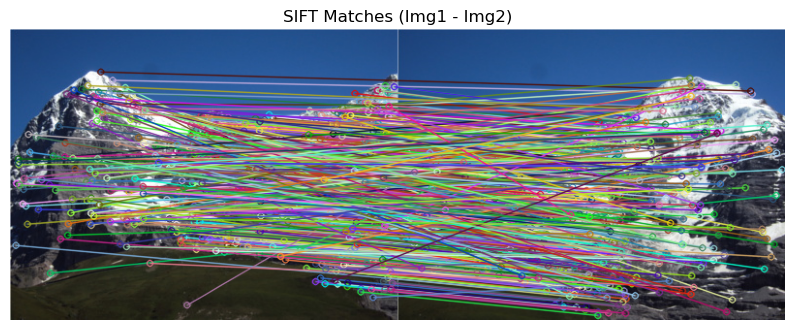

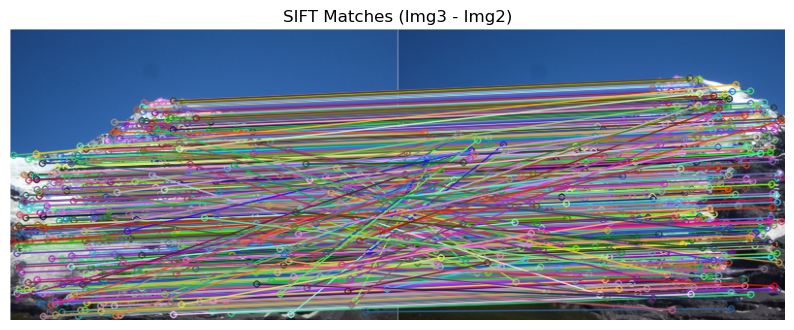

In [303]:
# Εκτύπωση αριθμού inliers και συνολικών matches
print("Img1-Img2: Inliers = {} / Total Matches = {}".format(len(inlier_matches12), len(matches12)))
print("Img3-Img2: Inliers = {} / Total Matches = {}".format(len(inlier_matches32), len(matches32)))

# Εμφάνιση SIFT matches
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_all_matches12, cv2.COLOR_BGR2RGB))
plt.title("SIFT Matches (Img1 - Img2)")
plt.axis("off")

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_all_matches32, cv2.COLOR_BGR2RGB))
plt.title("SIFT Matches (Img3 - Img2)")
plt.axis("off")

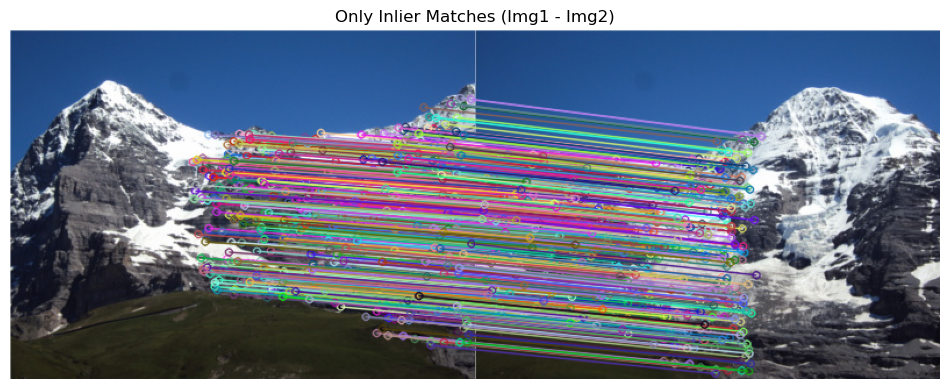

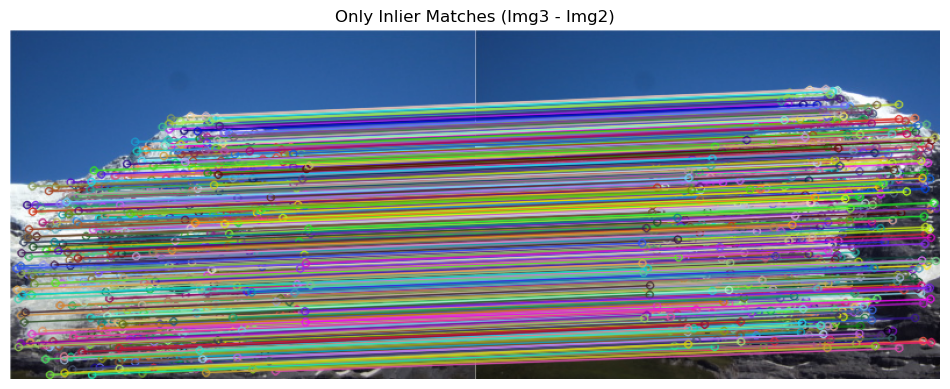

In [304]:
# Εμφάνιση μόνο των inliers
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_inliers12, cv2.COLOR_BGR2RGB))
plt.title("Only Inlier Matches (Img1 - Img2)")
plt.axis("off")

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_inliers32, cv2.COLOR_BGR2RGB))
plt.title("Only Inlier Matches (Img3 - Img2)")
plt.axis("off")
plt.show()

In [311]:

# Εφαρμόζουμε μετατόπιση T για να τοποθετήσουμε την img2 στο κέντρο του συστήματος.
w_ref = img2.shape[1]
T = np.array([[1, 0, w_ref],
              [0, 1, 0],
              [0, 0, 1]], dtype=np.float32)

H1_translated = T @ H1    # για img1
H2_translated = T         # για img2
H3_translated = T @ H3    # για img3

# Υπολογισμός των διαστάσεων του τελικού καμβά με τις μετασχηματισμένες γωνίες.
images = [img1, img2, img3]
transforms = [H1_translated, H2_translated, H3_translated]

pano_width, pano_height, x_min, y_min = compute_panorama_dimensions(images, transforms)
print("Panorama dimensions: {} x {} (offset: x_min={}, y_min={})".format(pano_width, pano_height, x_min, y_min))

# Δημιουργία translation matrix για μετατόπιση ώστε να έχουν θετικές τιμές οι συντεταγμένες
M = np.array([[1, 0, -x_min],
              [0, 1, -y_min],
              [0, 0, 1]], dtype=np.float32)

# Ορισμός μεγέθους πανοράματος
pan_size = (pano_width, pano_height)

### Εφαρμογή έτοιμης opencv συνάρτησης για καλύτερα αποτελέσματα ###

warp_img1 = cv2.warpPerspective(img1, M @ H1_translated, pan_size, 
                                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
warp_img2 = cv2.warpPerspective(img2, M @ H2_translated, pan_size, 
                                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
warp_img3 = cv2.warpPerspective(img3, M @ H3_translated, pan_size, 
                                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

### Δοκιμή custom υλοποίησης για εμφάνιση αποτελέσματος ###
custom_warp_img1 = custom_warp(img1, M @ H1_translated, pan_size, borderValue=(0,0,0))
custom_warp_img2 = custom_warp(img2, M @ H2_translated, pan_size, borderValue=(0,0,0))
custom_warp_img3 = custom_warp(img3, M @ H3_translated, pan_size, borderValue=(0,0,0))


Panorama dimensions: 743 x 365 (offset: x_min=214, y_min=-40)


(-0.5, 742.5, 364.5, -0.5)

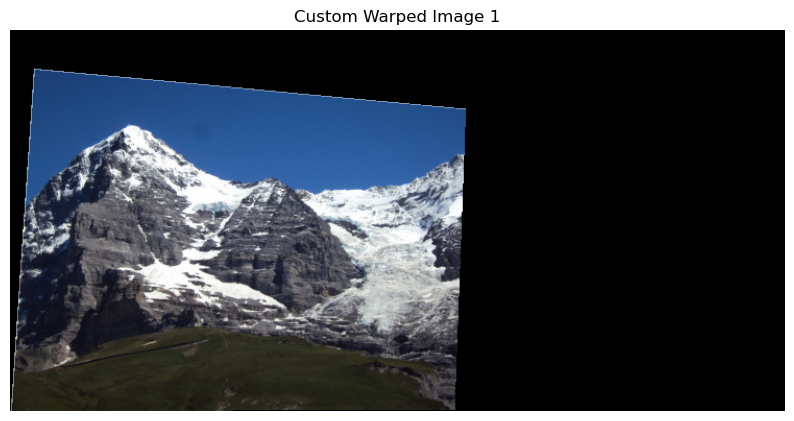

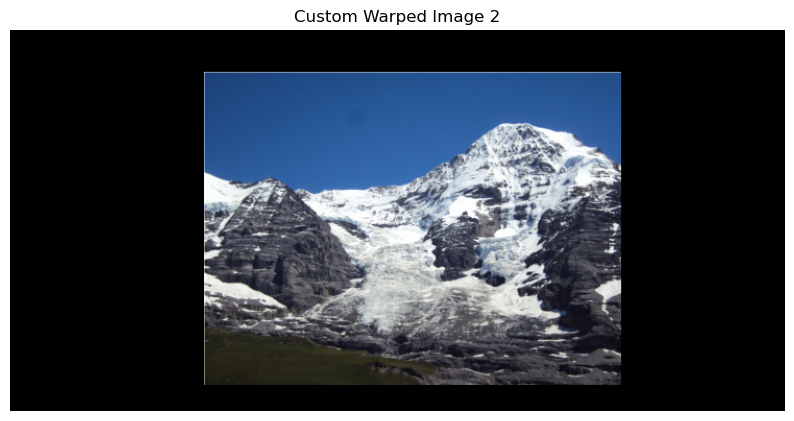

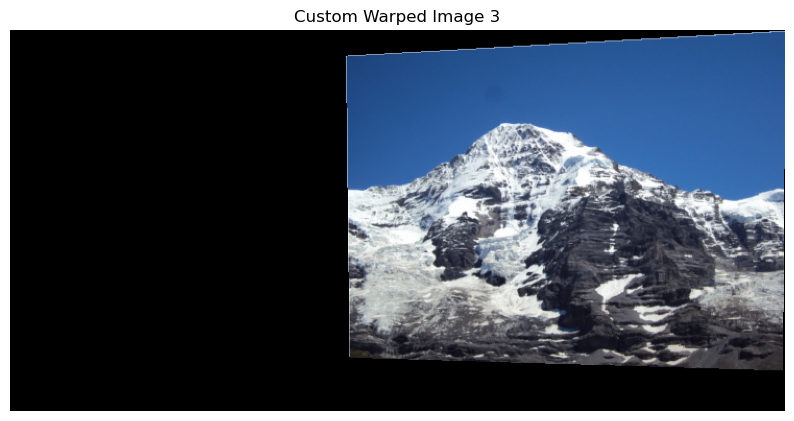

In [348]:
# Eμφάνιση των warp εικόνων με την custom υλοποίηση
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(custom_warp_img1, cv2.COLOR_BGR2RGB))
plt.title("Custom Warped Image 1")
plt.axis("off")

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(custom_warp_img2, cv2.COLOR_BGR2RGB))
plt.title("Custom Warped Image 2")
plt.axis("off")

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(custom_warp_img3, cv2.COLOR_BGR2RGB))
plt.title("Custom Warped Image 3")
plt.axis("off")


(-0.5, 742.5, 364.5, -0.5)

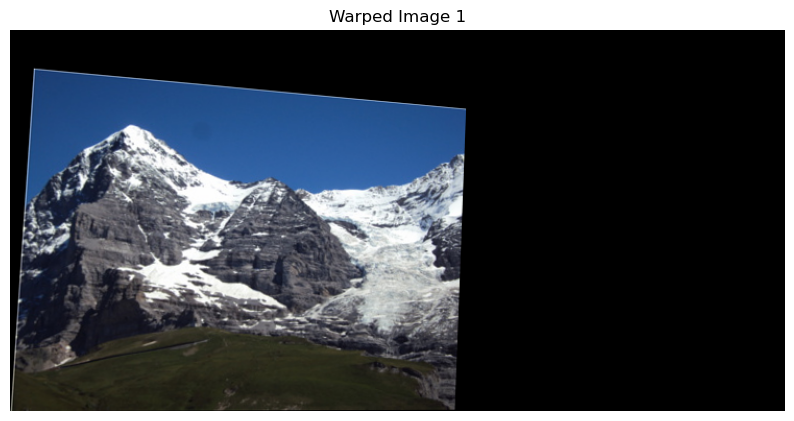

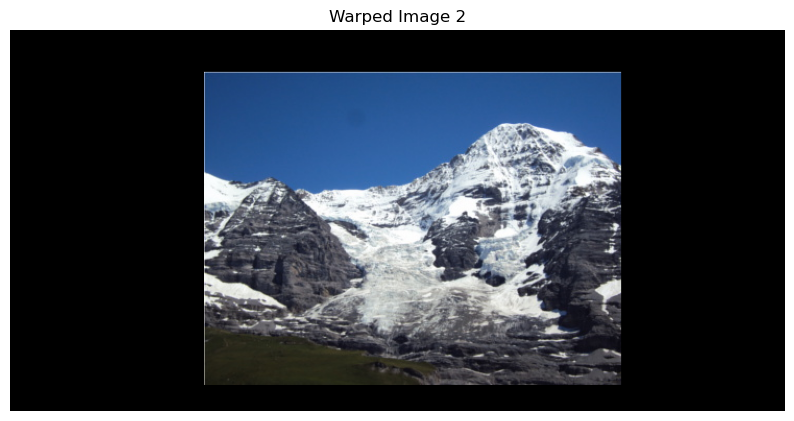

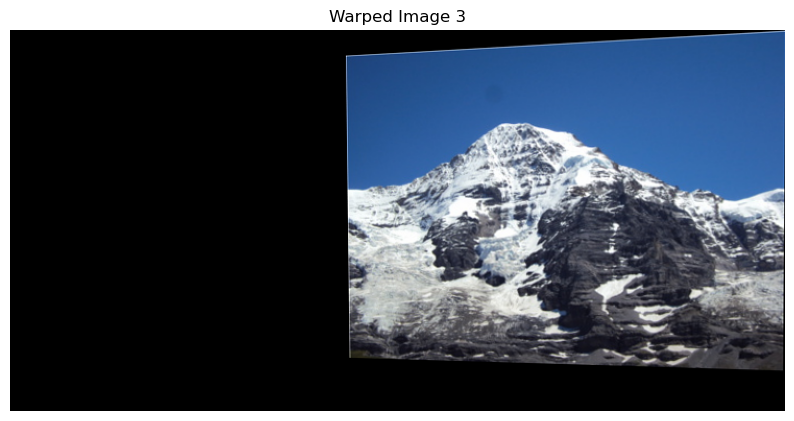

In [307]:
# Eμφάνιση των warp εικόνων με opencv συνάρτηση 
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(warp_img1, cv2.COLOR_BGR2RGB))
plt.title("Warped Image 1")
plt.axis("off")

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(warp_img2, cv2.COLOR_BGR2RGB))
plt.title("Warped Image 2")
plt.axis("off")

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(warp_img3, cv2.COLOR_BGR2RGB))
plt.title("Warped Image 3")
plt.axis("off")

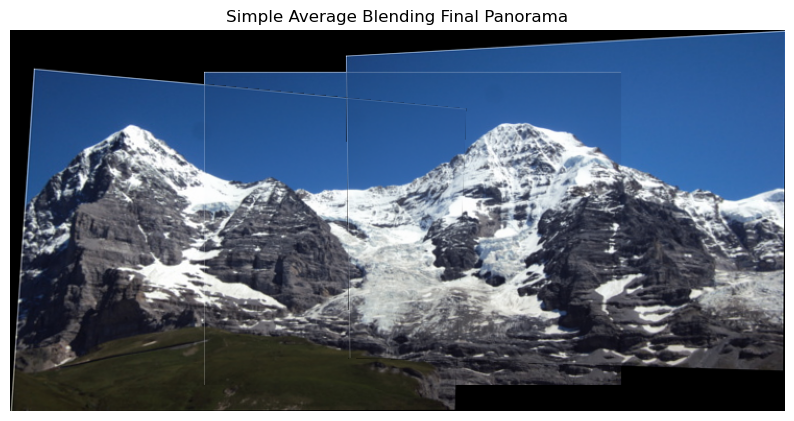

In [314]:
# Blending εικόνων με τη μέθοδο Simple Averaging
blend_12_simple = simple_blend(warp_img1, warp_img2)

panorama_simple = simple_blend(blend_12_simple, warp_img3)

# Εμφάνιση αποτελεσμάτων
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(blend_12_simple, cv2.COLOR_BGR2RGB))
plt.title("Simple Average Blending (Img1 & Img2)")
plt.axis("off")
    
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(panorama_simple, cv2.COLOR_BGR2RGB))
plt.title("Simple Average Blending Final Panorama")
plt.axis("off")
    
plt.show()

In [326]:
# Blending εικόνων με τη μέθοδο Linear Blending
alpha_value = 0.8
blend_12_linear = linear_blend(warp_img1, warp_img2, a=alpha_value)

panorama_linear = linear_blend(blend_12_linear, warp_img3, a=alpha_value)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(blend_12_linear, cv2.COLOR_BGR2RGB))
plt.title("Linear Blending (Img1 & Img2)")
plt.axis("off")

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(panorama_linear, cv2.COLOR_BGR2RGB))
plt.title(f"Linear Blending Final Panorama, a = {alpha_value}")
plt.axis("off")

(-0.5, 742.5, 364.5, -0.5)

In [328]:
# Blending εικόνων με τη μέθοδο Linear Blending With Weight
blend_12_linear_weight, _ = linear_blend_with_weight(warp_img1, warp_img2)


panorama_linear_weight, _ = linear_blend_with_weight(blend_12_linear_weight, warp_img3)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(blend_12_linear_weight, cv2.COLOR_BGR2RGB))
plt.title("Linear Blending With Weight(Img1 & Img2)")
plt.axis("off")

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(panorama_linear_weight, cv2.COLOR_BGR2RGB))
plt.title("Linear Blending With Weight Final Panorama")
plt.axis("off")


(-0.5, 742.5, 364.5, -0.5)

In [346]:
###### Laplacian Blending #######
def build_gaussian_pyramid(img, levels):
    """Δημιουργεί Gaussian πυραμίδα."""
    gp = [img.copy()]
    for i in range(levels):
        img = cv2.pyrDown(img)
        gp.append(img)
    return gp

def build_laplacian_pyramid(gp):
    """Δημιουργεί Laplacian πυραμίδα από την Gaussian πυραμίδα."""
    lp = []
    for i in range(len(gp)-1):
        GE = cv2.pyrUp(gp[i+1])
        GE = cv2.resize(GE, (gp[i].shape[1], gp[i].shape[0]))
        L = cv2.subtract(gp[i], GE)
        lp.append(L)
    lp.append(gp[-1])
    return lp


def laplacian_pyramid_blending_multiband(img1, img2, mask, levels=4):
    """
    Εφαρμόζει Laplacian Pyramid blending μεταξύ img1 και img2 χρησιμοποιώντας το overlap mask.
    """
    gp_img1 = build_gaussian_pyramid(img1.astype(np.float32), levels)
    gp_img2 = build_gaussian_pyramid(img2.astype(np.float32), levels)
    gp_mask = build_gaussian_pyramid(mask.astype(np.float32), levels)
    
    lp_img1 = build_laplacian_pyramid(gp_img1)
    lp_img2 = build_laplacian_pyramid(gp_img2)
    
    LS = []
    for L1, L2, gm in zip(lp_img1, lp_img2, gp_mask):
        if gm.ndim == 2:
            gm = gm[..., np.newaxis]  # Επέκταση μάσκας στα 3 κανάλια
        ls = L1 * gm + L2 * (1 - gm)
        LS.append(ls)
    
    blended = LS[-1]
    for i in range(levels-1, -1, -1):
        blended = cv2.pyrUp(blended)
        blended = cv2.resize(blended, (LS[i].shape[1], LS[i].shape[0]))
        blended = cv2.add(blended, LS[i])
    
    non_overlap = (mask == 1) | (mask == 0)
    blended[non_overlap] = np.where(img1[non_overlap] != 0, img1[non_overlap], img2[non_overlap])

    return np.clip(blended, 0, 255).astype(np.uint8)

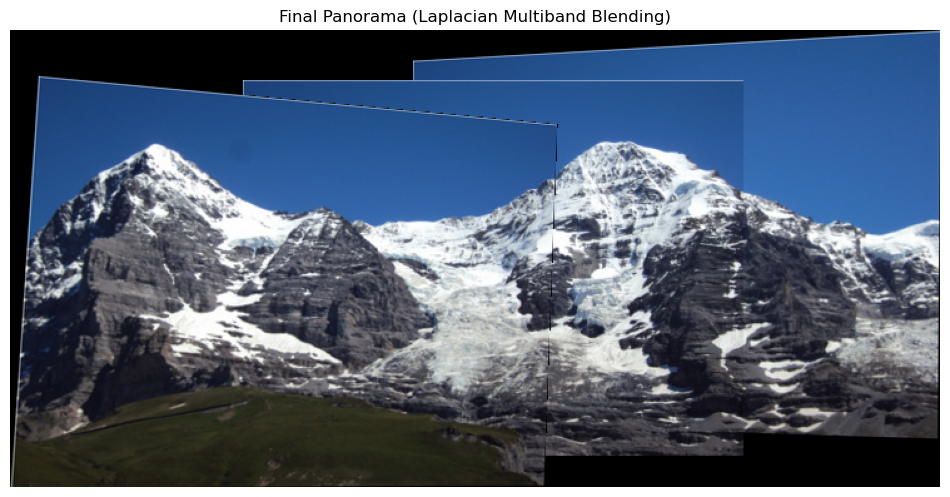

In [347]:
mask12 = create_overlap_mask(warp_img1, warp_img2)
mask23 = create_overlap_mask(warp_img2, warp_img3)

# Blending των δύο πρώτων εικόνων
blended12 = laplacian_pyramid_blending_multiband(warp_img1, warp_img2, mask12, levels=4)

# Blending με την τρίτη εικόνα
final_panorama = laplacian_pyramid_blending_multiband(blended12, warp_img3, mask23, levels=4)

# Εμφάνιση του τελικού πανόραμα
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(final_panorama, cv2.COLOR_BGR2RGB))
plt.title("Final Panorama (Laplacian Multiband Blending)")
plt.axis("off")
plt.show()